In [65]:
# Extract sift feature from the image

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.metrics import pairwise_distances_argmin_min


num_of_centroids=4096
num_train_samples=300
num_test_samples=100

all_image_idx=random.sample(range(0,400),400)

def remove_noise (image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    median = cv2.medianBlur(gray, 3)
    sharpen = cv2.Canny(median, 100,250)
    return sharpen


def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
NUM_OF_DESCRIPTORS_PER_IMAGE = 200

all_des=np.empty((1,128))
labels = np.array([])

#SIFT
sift = cv2.SIFT_create()
for i in range (100):
    image = cv2.imread("../../fonts-dataset/Lemonada/"+str(i)+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]
    
    print(sorted_descriptors.shape)
    if sorted_descriptors is not None :
        all_des=np.vstack((all_des,sorted_descriptors))
        labels=np.append(labels,0)
    
    image2 = cv2.imread("../../fonts-dataset/Marhey/"+str(i)+".jpeg")
    removed_noise2 = remove_noise(image2)
    kp , descriptors= sift.detectAndCompute(removed_noise2,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]

    if sorted_descriptors is not None :
        all_des=np.vstack((all_des,sorted_descriptors))
        labels=np.append(labels,1)

    image3 = cv2.imread("../../fonts-dataset/IBM Plex Sans Arabic/"+str(i)+".jpeg")
    removed_noise3 = remove_noise(image3)
    kp , descriptors= sift.detectAndCompute(removed_noise3,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]

    if sorted_descriptors is not None :
        all_des=np.vstack((all_des,sorted_descriptors))
        labels=np.append(labels,2)

    image4 = cv2.imread("../../fonts-dataset/Scheherazade New/"+str(i)+".jpeg")
    removed_noise4 = remove_noise(image4)
    kp , descriptors= sift.detectAndCompute(removed_noise4,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]

    if sorted_descriptors is not None :
        all_des=np.vstack((all_des,sorted_descriptors))
        labels=np.append(labels,3)
    
    print(i)

print((all_des).shape)
X_train, X_test, y_train, y_test = train_test_split(all_des, labels, test_size=0.2, random_state=42)
kmeans=KMeans(n_clusters=4).fit(all_des)

img=cv2.drawKeypoints(removed_noise,kp,image)
show_images([img])

NameError: name 'np' is not defined

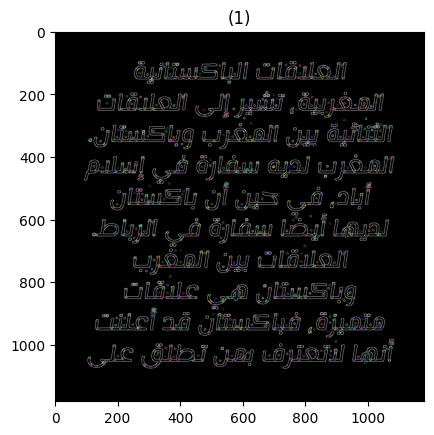

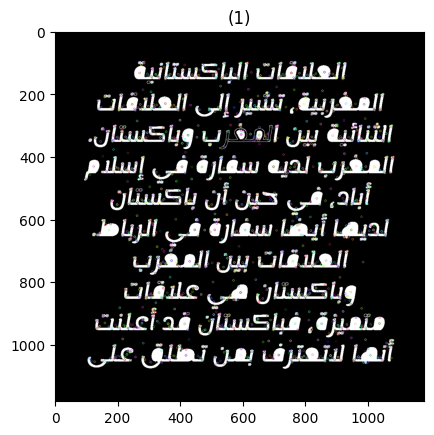

In [9]:
# Temp
x=remove_noise(cv2.imread("../../fonts-dataset/Lemonada/19.jpeg"))
res=cv2.findContours(x,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
conts=res[-2]
image2=cv2.fillPoly(x,pts=conts,color=(255,255,255))
show_images([image])
kp , descriptors= sift.detectAndCompute(image2,None)
img2=cv2.drawKeypoints(image2,kp,image)
show_images([img])

In [19]:
# now use a classifier to classify the images, lets try SVM 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X=[]
y=[]

for i in range (800 , 1000):
    image = cv2.imread("../../fonts-dataset/Lemonada/"+str(i)+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)
    if descriptors is not None:
        hist=np.zeros(4)
        for des in descriptors:
            idx=kmeans.predict([des])
            hist[idx]+=1
        X.append(hist)
        y.append(0)

    image2 = cv2.imread("../../fonts-dataset/Marhey/"+str(i)+".jpeg")
    removed_noise2 = remove_noise(image2)
    kp , descriptors= sift.detectAndCompute(removed_noise2,None)
    if descriptors is not None:
        hist=np.zeros(4)
        for des in descriptors:
            idx=kmeans.predict([des])
            hist[idx]+=1
        X.append(hist)
        y.append(1)

    image3 = cv2.imread("../../fonts-dataset/IBM Plex Sans Arabic/"+str(i)+".jpeg")
    removed_noise3 = remove_noise(image3)
    kp , descriptors= sift.detectAndCompute(removed_noise3,None)
    if descriptors is not None:
        hist=np.zeros(4)
        for des in descriptors:
            idx=kmeans.predict([des])
            hist[idx]+=1
        X.append(hist)
        y.append(2)

    image4 = cv2.imread("../../fonts-dataset/Scheherazade New/"+str(i)+".jpeg")
    removed_noise4 = remove_noise(image4)
    kp , descriptors= sift.detectAndCompute(removed_noise4,None)
    if descriptors is not None:
        hist=np.zeros(4)
        for des in descriptors:
            idx=kmeans.predict([des])
            hist[idx]+=1
        X.append(hist)
        y.append(3)

X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)

fares1


KeyboardInterrupt: 

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='poly', C=0.1, random_state=0, coef0=1, degree=4, gamma=10.0,class_weight= None)
x_train = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]
y_train = [1,2,3,4,5,6,7,8,9,10]
x_test  = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]
y_test = [1,2,3,4,5,6,7,8,9,10]
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print(accuracy_score(y_test, y_pred)*100)


100.0


In [66]:
from sklearn.neighbors import KNeighborsClassifier
## KNN

from sklearn.model_selection import train_test_split
NUM_OF_DESCRIPTORS_PER_IMAGE = 400
NUMBER_OF_ITERATIONS = 100

counter = 0

all_des= []
labels = np.array([])

#SIFT
sift = cv2.SIFT_create()
for i in range (NUMBER_OF_ITERATIONS):
    image = cv2.imread("../../fonts-dataset/Lemonada/"+str(i)+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]
    sorted_descriptors = sorted_descriptors.reshape(1,-1)
    
    if (sorted_descriptors is not None) and  sorted_descriptors.shape[1] == 128*NUM_OF_DESCRIPTORS_PER_IMAGE:
        all_des.append(sorted_descriptors)
        labels=np.append(labels,0)
    else:
        counter+=1

    image2 = cv2.imread("../../fonts-dataset/Marhey/"+str(i)+".jpeg")
    removed_noise2 = remove_noise(image2)
    kp , descriptors= sift.detectAndCompute(removed_noise2,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]
    ## reshape the sorted_descriptors to 1D array
    sorted_descriptors = sorted_descriptors.reshape(1,-1)

    if (sorted_descriptors is not None) and  sorted_descriptors.shape[1] == 128*NUM_OF_DESCRIPTORS_PER_IMAGE:
        all_des.append(sorted_descriptors)
        labels=np.append(labels,1)
    else:
        counter+=1

    image3 = cv2.imread("../../fonts-dataset/IBM Plex Sans Arabic/"+str(i)+".jpeg")
    removed_noise3 = remove_noise(image3)
    kp , descriptors= sift.detectAndCompute(removed_noise3,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]
    sorted_descriptors = sorted_descriptors.reshape(1,-1)

    if (sorted_descriptors is not None) and  sorted_descriptors.shape[1] == 128*NUM_OF_DESCRIPTORS_PER_IMAGE:
        all_des.append(sorted_descriptors)
        labels=np.append(labels,2)
    else:
        counter+=1

    image4 = cv2.imread("../../fonts-dataset/Scheherazade New/"+str(i)+".jpeg")
    removed_noise4 = remove_noise(image4)
    kp , descriptors= sift.detectAndCompute(removed_noise4,None)

    scores= [p.response for p in kp]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_keypoints = [kp[i] for i in sorted_indices]
    sorted_descriptors = descriptors[sorted_indices[0:NUM_OF_DESCRIPTORS_PER_IMAGE]]
    sorted_descriptors = sorted_descriptors.reshape(1,-1)

    if (sorted_descriptors is not None) and  sorted_descriptors.shape[1] == 128*NUM_OF_DESCRIPTORS_PER_IMAGE:
        all_des.append(sorted_descriptors)
        labels=np.append(labels,3)
    else:
        counter+=1

    print(i)

print(len(all_des)) # 100*4, 200*128
# convert the list to numpy array
all_des = np.array(all_des)
print(all_des.shape)
## reshape the all_des to 2D array
all_des = all_des.reshape(NUMBER_OF_ITERATIONS*4 -counter, 128*NUM_OF_DESCRIPTORS_PER_IMAGE)

X_train, X_test, y_train, y_test = train_test_split(all_des, labels, test_size=0.2, random_state=42)

clf = KNeighborsClassifier(n_neighbors=11)
tree = clf.fit(X_train, y_train)
results = tree.predict(X_test)
print(accuracy_score(y_test, results)*100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
392
(392, 1, 51200)
35.44303797468354


In [ ]:
all_des=np.empty((1,128))

#SIFT
sift = cv2.SIFT_create()

num_of_desc=[]

for i in range (num_train_samples):
    image = cv2.imread("../../fonts-dataset/IBM Plex Sans Arabic/"+str(all_image_idx[i])+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)
    if descriptors is not None:
        all_des=np.vstack((all_des,descriptors))
    print("processing type 1 image"+str(i))


num_of_desc+=[all_des.shape[0]]
print("FINISHED READING FIRST SET OF IMAGES")

for i in range (num_train_samples):
    image = cv2.imread("../../fonts-dataset/Lemonada/"+str(all_image_idx[i])+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)
    if descriptors is not None:
        all_des=np.vstack((all_des,descriptors))
    print("processing type 2 image"+str(i))

num_of_desc+=[all_des.shape[0]]

print("FINISHED READING SECOND SET OF IMAGES")

for i in range (num_train_samples):
    image = cv2.imread("../../fonts-dataset/Marhey/"+str(all_image_idx[i])+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)
    if descriptors is not None:
        all_des=np.vstack((all_des,descriptors))
    print("processing type 3 image"+str(i))

num_of_desc+=[all_des.shape[0]]
print("FINISHED READING THIRD SET OF IMAGES")


for i in range (num_train_samples):
    image = cv2.imread("../../fonts-dataset/Scheherazade New/"+str(all_image_idx[i])+".jpeg")
    removed_noise = remove_noise(image)
    kp , descriptors= sift.detectAndCompute(removed_noise,None)
    if descriptors is not None:
        all_des=np.vstack((all_des,descriptors))
    print("processing type 4 image"+str(i))

num_of_desc+=[all_des.shape[0]]
print("FINISHED READING FOURTH SET OF IMAGES")

desc_labels=np.zeros(all_des.shape[0])
desc_labels[num_of_desc[0]:num_of_desc[1]]=1
desc_labels[num_of_desc[1]+1:num_of_desc[2]]=2
desc_labels[num_of_desc[2]+1:num_of_desc[3]]=3

In [ ]:
# different options for kmeans
# - mini batches
# - limiting the number of descriptors
kmeans=MiniBatchKMeans(n_clusters=num_of_centroids,batch_size=num_of_centroids*1024,max_iter=20).fit(X=all_des)

In [ ]:
print(kmeans.cluster_centers_.shape)
print(kmeans.labels_.shape)
print(desc_labels.shape)

In [ ]:
centroids_labels=np.zeros((num_of_centroids,4))
for i in range(num_of_centroids):
    centroids_labels[i][0]=(np.sum(desc_labels[kmeans.labels_==i]==0))
    centroids_labels[i][1]=(np.sum(desc_labels[kmeans.labels_==i]==1))
    centroids_labels[i][2]=(np.sum(desc_labels[kmeans.labels_==i]==2))
    centroids_labels[i][3]=(np.sum(desc_labels[kmeans.labels_==i]==3))
    centroids_labels[i]/=np.sum(centroids_labels[i])

In [ ]:
def predict(path,centroids,centroids_labels):
    image=cv2.imread(path)
    removed_noise = remove_noise(image)
    _ , descriptors= sift.detectAndCompute(removed_noise,None)

    predections=[0.0,0.0,0.0,0.0]
    if descriptors is not None:
        for des in descriptors:
            idx=kmeans.predict([des])
            dist=np.linalg.norm(des-centroids[idx])
            if dist == 0:
                dist = 0.0000001
            predections+=(centroids_labels[idx]/dist)
        return np.argmax(predections)
    else:
        return -1

from sklearn.neighbors import NearestNeighbors
K = 11
def predict_knn(path,centroids,centroids_labels,knn):
    image=cv2.imread(path)
    removed_noise = remove_noise(image)
    _ , descriptors= sift.detectAndCompute(removed_noise,None)

    predections=[0.0,0.0,0.0,0.0]
    if descriptors is not None:
        for des in descriptors:
            neigh=knn.kneighbors([des])
            for i in range(K):
                predections+=(centroids_labels[neigh[1][0][i]]/neigh[0][0][i])
        print(predections)
        return np.argmax(predections)
    else:
        return -1

num_right0=0
num_right1=0
num_right2=0
num_right3=0

predictions=[]

for i in range (num_test_samples):
    rand_idx=str(all_image_idx[num_train_samples+i])
    path="../../fonts-dataset/IBM Plex Sans Arabic/"+rand_idx+".jpeg"

    predicted=predict(path,kmeans.cluster_centers_,centroids_labels)
    print("image",(rand_idx), "type0: ",predicted)
    num_right0+=predicted==0
    predictions.append(predicted)

for i in range (num_test_samples):
    rand_idx=str(all_image_idx[num_train_samples+i])
    path="../../fonts-dataset/Lemonada/"+rand_idx+".jpeg"

    predicted=predict(path,kmeans.cluster_centers_,centroids_labels)
    print("image",(rand_idx), "type1: ",predicted)
    num_right1+=predicted==1
    predictions.append(predicted)

for i in range (num_test_samples):
    rand_idx=str(all_image_idx[num_train_samples+i])

    path="../../fonts-dataset/Marhey/"+rand_idx+".jpeg"

    predicted=predict(path,kmeans.cluster_centers_,centroids_labels)
    print("image",(rand_idx), "type2: ",predicted)
    num_right2+=predicted==2
    predictions.append(predicted)

for i in range (num_test_samples):
    rand_idx=str(all_image_idx[num_train_samples+i])

    path="../../fonts-dataset/Scheherazade New/"+rand_idx+".jpeg"

    predicted=predict(path,kmeans.cluster_centers_,centroids_labels)
    print("image",(rand_idx), "type3: ",predicted)
    num_right3+=predicted==3
    predictions.append(predicted)

In [ ]:
print(num_right0)
print(num_right1)
print(num_right2)
print(num_right3)

In [ ]:
print((num_right0+num_right1+num_right2+num_right3)/(4*num_test_samples))

In [ ]:
img=cv2.imread("../../fonts-dataset/Marhey/233.jpeg")
removed_noise=remove_noise(img)
_ , descriptors= sift.detectAndCompute(removed_noise,None)

predections=[0.0,0.0,0.0,0.0]
for des in descriptors:
    idx=kmeans.predict([des])
    dist=np.linalg.norm(des-kmeans.cluster_centers_[idx])
    predections+=(centroids_labels[idx]/dist)
print(predections)

show_images([removed_noise])


In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)
classes=np.arange(0, num_of_centroids, 1, dtype=int)
knn.fit(kmeans.cluster_centers_,classes)
_ , descriptors= sift.detectAndCompute(removed_noise,None)

predections=[0.0,0.0,0.0,0.0]
for des in descriptors:
    idx=knn.predict([des])
    dist=np.linalg.norm(des-kmeans.cluster_centers_[i])
    predections+=(centroids_labels[idx]/dist)
print(predections)

In [4]:
all_des=[]
arr = [[1,2,3],[3,4,5]]
all_des+=arr
all_des+=arr
print(all_des)


[[1, 2, 3], [3, 4, 5], [1, 2, 3], [3, 4, 5]]
